In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib

from ATARI.sammy_interface import sammy_classes, sammy_functions

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from copy import copy

import plotting as myplot


In [2]:
sammypath = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy'

In [3]:
# %matplotlib widget

# Overview

The synthetic data methodology build here is modeled after measurement data from the work of Jesse Brown at RPI (currently at ORNL).
These measurements are detailed in https://www.tandfonline.com/doi/full/10.1080/00295639.2023.2249786 and consist of 6 experimental configurations.
Of the 4 transmission measurements only 3 are used for evaluation and the 4th (45m FP) is used for validation. 
Both 2 capture measurements are used for evaluation.

The evaluation transmission data are reliable in the range 0.15-100 keV.
The capture data are reliable from 0.15-200 keV. 
The validation transmission data are reliable in the range 0.003-100 keV.

The data that are available are *reduced* data, generally in EXFOR. 
This is what is imported for the evaluation datasets.
Reduced data can be modelled with SAMMY, which models the particle-pair reaction and the experimental conditions.
In ATARI, this is referred to as the theoretical and experimental models.

Ultimately, for the synthetic data methodology, we will need information about the data reduction process.
This information is referred to in ATARI as the measurement model.
Ideally, this information comes from the experimentalist and you have access to all of the parameters used in the reduction process. 
The synthetic data methodology was developed alongside Jesse Brown, therefore, this is the scenario for the 12mm/45mFP validations measurements.
However, this ideal scenario is not always possible and is not the case for the 5 evaluation measurements.

This notebook does the following:
1. Generates synthetic data for the validation case and does a detailed comparison to the real measurement data made possible by full access to the data reduction process.
2. Generates synthetic data for the evaluation cases by making some approximations and assumptions about the reduction process.
3. Does a less-detailed comparison of the synthetic evaluation data to the reduced evaluation measurement data.


# 1. Validation Case

To reiterate, the synthetic data methodology for the 12mm validation measurement is fully informed. 
It has access to the exact reduction parameters (including background and open neutron spectrum) and the raw data itself.
This allows for higher-utility synthetic data and more rigorous statistical comparisons to the real data. 
A journal article detailing this case is can be found at https://doi.org/10.1016/j.cpc.2023.108927.

In [4]:
### import reduced data
transdat12 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-12mm.dat"))
# transdat12_covfile = Need to generate from sys and stat covariances
exptrans12 = Experimental_Model(title = "trans12",
                                reaction = "transmission",
                                energy_range = (3,2500),
                                energy_grid = np.sort(transdat12.E.values),
                                template = os.path.realpath("./data/template_trans12_edited"),
                                sammy_inputs = {
                                    'alphanumeric'       :   ["BROADENING IS WANTED"],
                                    'ResFunc'            :   "ORRES"
                                        },

                                n = (0.067166, 0.0),  
                                FP = (35.185,0.0), 
                                burst = (8,0.0), 
                                temp = (294.2610, 0.0),

                                channel_widths={
                                        "maxE": [26.23   , 110.79  , 2014.67 , 30889.79], 
                                        "chw": [409.6, 204.8,  25.6,  25.6],
                                        "dchw": [0.8]
                                        },

                                additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000", "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
                               )

transdat12 = transdat12[(transdat12.E<max(exptrans12.energy_range)) & (transdat12.E>min(exptrans12.energy_range))]

### import raw data
trans12_explicit_covariance = np.load(os.path.realpath("./data/JB_cov.npy"))
jb_raw_data = pd.read_csv(os.path.realpath("./data/JB_reduction_data.csv"), index_col='Unnamed: 0')
jb_raw_data = jb_raw_data[(jb_raw_data.e<max(exptrans12.energy_range)) & (jb_raw_data.e>min(exptrans12.energy_range))]

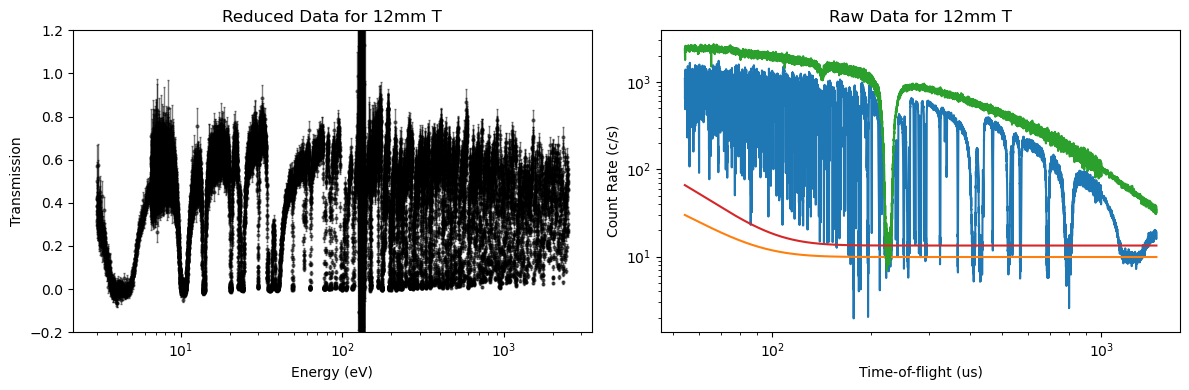

In [5]:
importlib.reload(myplot)

# plot transmission
fig, axes = subplots(1,2, figsize=(12,4))

axes[0].errorbar(transdat12.E, transdat12.exp, yerr= transdat12.exp_unc,
                  fmt='.', alpha=0.5, color='k', linewidth=1.0, markersize=4, capsize=1, label=exptrans12.title)
axes[0].set_xscale('log')
# axes[0].set_yscale('log')
axes[0].set_ylim([-0.2, 1.2])
axes[0].set_xlabel("Energy (eV)")
axes[0].set_title("Reduced Data for 12mm T")
axes[0].set_ylabel("Transmission")



axes[1].plot(jb_raw_data.tof, jb_raw_data.cs)
axes[1].plot(jb_raw_data.tof, jb_raw_data.bs)

axes[1].plot(jb_raw_data.tof, jb_raw_data.co)
axes[1].plot(jb_raw_data.tof, jb_raw_data.bo)

axes[1].set_xscale('log')
axes[1].set_yscale('log')

axes[1].set_xlabel("Time-of-flight (us)")
axes[1].set_ylabel("Count Rate (c/s)")
axes[1].set_title("Raw Data for 12mm T")


# axes[2].imshow(trans12_explicit_covariance)
# imshow(trans12_explicit_covariance, vmin=-.1, vmax=.1)

# axes[2].colorbar()


fig.tight_layout()

### Approximate the resonances that generated this data

Synthetic data can be generated around any point-wise vector (of the experimental object transmission or capture yield) that is taken as 'true'.
In order to better compare synthetic data to real data, we must approximate the resonance structures that generated the real data and use those as 'true'
For this, you can take the evaluated JEFF parameters or fit the new data from those parameters.


In [6]:
rto = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True
                              })

matnum = 7328
jeff_file = os.path.realpath("./data/73-Ta-181g.jeff33")
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, rto)

energy_range_all = (4, 2500)
jeff_parameters = jeff_parameters[(jeff_parameters.E<max(exptrans12.energy_range)) & (jeff_parameters.E>min(exptrans12.energy_range))]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*0
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))


### setup the reaction model - Ta-181 is the default
Ta_pair = Particle_Pair()      

sammyINP = sammy_classes.SammyInputData(
    Ta_pair,
    jeff_parameters,
    os.path.realpath("./data/template_trans12_edited"),
    exptrans12,
    experimental_data=transdat12,
    # experimental_covariance = datasample.covariance_data
    initial_parameter_uncertainty=1
)

sammyOUT = sammy_functions.run_sammy(sammyINP, rto)
print(sammyOUT.chi2)
print(sammyOUT.chi2_post)

None
43107.4


In [7]:
print(sammyOUT.chi2)
print(sammyOUT.chi2_post)

None
43107.4


Text(0, 0.5, 'Transmission')

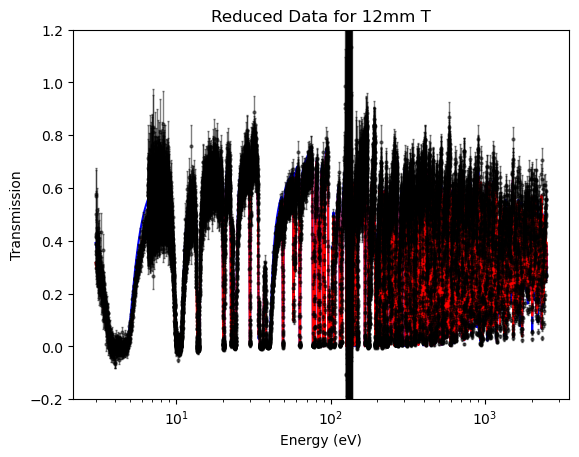

In [8]:

# plot transmission
figure()

errorbar(transdat12.E, transdat12.exp, yerr= transdat12.exp_unc, #zorder=0,
                  fmt='.', alpha=0.5, color='k', linewidth=1.0, markersize=4, capsize=1, label=exptrans12.title)

plot(sammyOUT.pw_post.E, sammyOUT.pw.theo_trans, color='b', zorder=1)
plot(sammyOUT.pw_post.E, sammyOUT.pw_post.theo_trans_bayes, color='r', zorder=1)

xscale('log')
# axes[0].set_yscale('log')
ylim([-0.2, 1.2])
xlabel("Energy (eV)")
title("Reduced Data for 12mm T")
ylabel("Transmission")


### Build a corresponding Syndat model

Syndat needs both a generative and reductive measurement model. 
The generative model is considered 'true' and is used to generate statistical samples of raw data such as count rates or background functions. 
The raw data are then put through the data reduction model to get to the reduced transmission. 
For now, we can assume that the generative and reductive models are the same.

The parameters used by Jesse Brown in the taking of this data are those given as defaults for the Transmission_RPI measurement model.
The only non-default parameter is the open spectrum. 
Syndat, by default, approximates this with an exponential function. 
If the user has access to the actual open spectrum, then it is preferred to supply it.



In [10]:
from ATARI.syndat import syndat_model
importlib.reload(syndat_model)
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT

### define measurement models
open_df = copy(jb_raw_data[["e", "tof", "cto", "dcto"]])
open_df.rename(columns={"e":"E", "cto":"ct", "dcto":"dct"}, inplace=True)
open_df['tof'] = open_df['tof']*1e3
open_df['bw'] = abs(np.append(np.diff(open_df['tof']), np.diff(open_df['tof'])[-1])*1e-9)

trans12mm_gen_meas = Transmission_RPI(open_neutron_spectrum = open_df)
trans12mm_red_meas = Transmission_RPI(open_neutron_spectrum = open_df)

### define syndat options and model, do not sample resonances
synOPT = syndatOPT(sampleRES=False, calculate_covariance=True, explicit_covariance=True, save_raw_data=True)

syndat_trans12mm = syndat_model.Syndat_Model(exptrans12,
                            trans12mm_gen_meas,
                            trans12mm_red_meas,
                            options = synOPT,
                            title='trans12mm')

### set the resonance ladder for the reaction model and draw samples
Ta_pair.resonance_ladder = copy(sammyOUT.par_post)
rto.bayes = False
syndat_trans12mm.sample(particle_pair=Ta_pair, 
                    sammyRTO=rto,
                    num_samples=1)

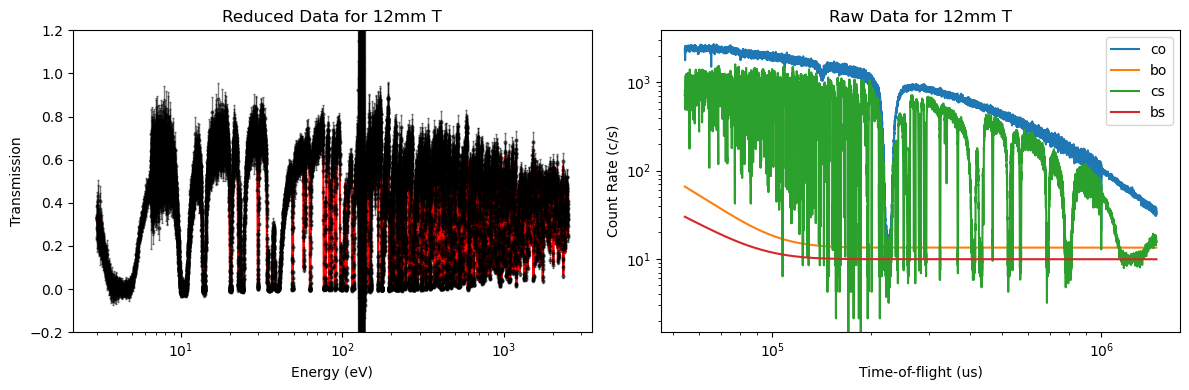

In [11]:
red_data = syndat_trans12mm.samples[0].pw_reduced
raw_data = syndat_trans12mm.samples[0].pw_raw

# plot transmission
fig, axes = subplots(1,2, figsize=(12,4))

axes[0].errorbar(red_data.E, red_data.exp, yerr=red_data.exp_unc,
                  fmt='.', alpha=0.5, color='k', linewidth=1.0, markersize=4, capsize=1, label=exptrans12.title)
axes[0].plot(red_data.E, red_data.true, color='r', zorder=1)

axes[0].set_xscale('log')
# axes[0].set_yscale('log')
axes[0].set_ylim([-0.2, 1.2])
axes[0].set_xlabel("Energy (eV)")
axes[0].set_title("Reduced Data for 12mm T")
axes[0].set_ylabel("Transmission")


axes[1].plot(raw_data.tof, raw_data.co, label='co')
axes[1].plot(raw_data.tof, raw_data.bo, label='bo')

axes[1].plot(raw_data.tof, raw_data.cs, label='cs')
axes[1].plot(raw_data.tof, raw_data.bs, label='bs')

axes[1].set_xscale('log')
axes[1].set_yscale('log')

axes[1].set_xlabel("Time-of-flight (us)")
axes[1].set_ylabel("Count Rate (c/s)")
axes[1].set_title("Raw Data for 12mm T")


# axes[2].imshow(trans12_explicit_covariance)
# imshow(trans12_explicit_covariance, vmin=-.1, vmax=.1)

# axes[2].colorbar()
axes[1].legend()

fig.tight_layout()

In [12]:
### now if you want to generate data with random resonances, supply average reosnance parameters

# # add spin group information for both s-wave resonances
# Ta_pair.add_spin_group(Jpi='3.0',
#                        J_ID=1,
#                        D=9.0030,
#                        gn2_avg=452.56615, 
#                        gn2_dof=1,
#                        gg2_avg=32.0,
#                        gg2_dof=1000)

# Ta_pair.add_spin_group(Jpi='4.0',
#                        J_ID=2,
#                        D=8.3031,
#                        gn2_avg=332.24347, 
#                        gn2_dof=1,
#                        gg2_avg=32.0,
#                        gg2_dof=1000)

### Comparing how the data is distributed

For the 12mm transmission data, full access to the reduction model and experimentalist that produced the data allows for the highest utility synthetic data.
A full statistical comparison is done in an associated journal publication: (https://www.sciencedirect.com/science/article/pii/S0010465523002722)
Here, we do just a simplified investigation of the distributions structure.
Remember, the synthetic data distribution is an ensemble and the real data is just a single realization.

The following distributions are constructed after filtering the data to areas of the RRR that are well-represented by the fit (150< eV < 850).


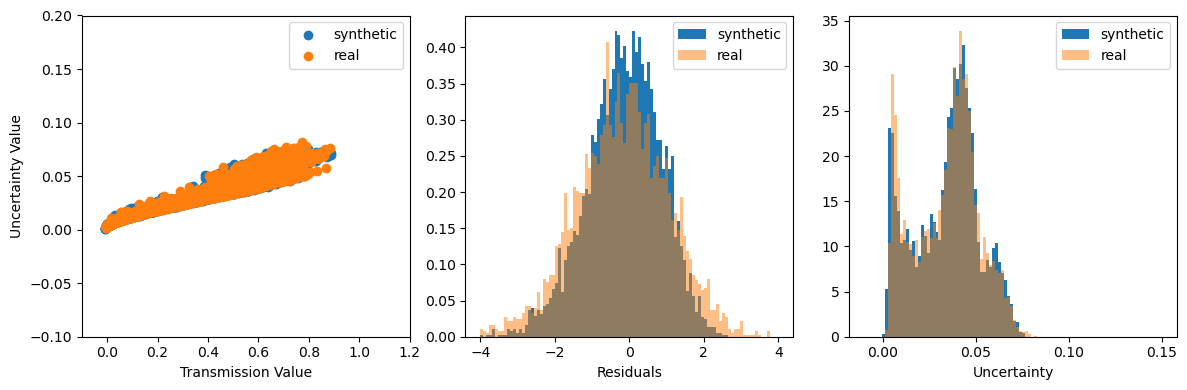

In [13]:
mask = (red_data.E>150.0) & (red_data.E<850)
synthetic_data = red_data[mask]
real_data = transdat12[mask]


fig, axes = subplots(1,3, figsize=(12,4))

axes[0].scatter(synthetic_data.exp, synthetic_data.exp_unc, label='synthetic')
axes[0].scatter(real_data.exp, real_data.exp_unc, label='real')
axes[0].set_xlim([-0.1,1.2])
axes[0].set_ylim([-0.1, 0.2])
axes[0].set_ylabel("Uncertainty Value")
axes[0].set_xlabel("Transmission Value")

bins = 100
range = (-4,4)
_ = axes[1].hist((synthetic_data.exp-synthetic_data.true)/synthetic_data.exp_unc, bins=bins, range=range, density=True,label='synthetic') #-red_data.true
_ = axes[1].hist((real_data.exp-synthetic_data.true)/real_data.exp_unc, bins=bins, range=range, alpha=0.5,density=True, label='real')#-red_data.true
axes[1].set_xlabel("Residuals")
# range = (-0.1, 1.2)
# _ = axes[1].hist((synthetic_data.exp), bins=bins, range=range, density=True,label='synthetic')  #-red_data.true
# _ = axes[1].hist((real_data.exp), bins=bins, range=range, alpha=0.5,density=True, label='real') #-red_data.true
# axes[1].set_xlabel("Experimental Values")

bins = 100
range = (-.01,.15)
_ = axes[2].hist(synthetic_data.exp_unc, bins=bins, range=range, density=True,label='synthetic')
_ = axes[2].hist(real_data.exp_unc, bins=bins, range=range, alpha=0.5, density=True,label='real')
axes[2].set_xlabel("Uncertainty")

for ax in axes:
    ax.legend()
    
fig.tight_layout()

# 1, 3, & 6 mm Transmission Measurements

For these measurement models, we do not have access to the raw data or the full data-reduction model like we did for the 12mm validation case.
Instead, we only have access to the published journal article for the measurements, an appropriate resolution function, and the reduced data in EXFOR.
We must glean the necessary information for the ATARI.syndat measurement models from these sources.

In [14]:

### Determine channel widths
from ATARI.theory.experimental import e_to_t, t_to_e

def get_chw_and_upperE(E, FP):
    E = np.array(E)
    tof = e_to_t(E, FP, True)
    dt = np.diff(tof*1e6)
    widths1, index1 = np.unique(np.round(dt, 4), return_index=True)
    chw, Emax = np.flipud(widths1), np.flipud(E[index1])
    strc = ''
    stre = ''
    for c,e in zip(chw, Emax):
        strc += f"{c*1e3:.2f}, "
        stre += f"{e:.2f}, "
    return stre, strc



energy_range_T = [0.15e3, 200e3]

### 1mm Transmission data
transdat1 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-1mm.twenty"))
transdat1_covfile = os.path.realpath('./data/trans-Ta-1mm.idc')

chw, Emax = get_chw_and_upperE(transdat1.E, 100.14)

exptrans1 = Experimental_Model(title = "trans1mm",
                               reaction = "transmission", 
                               energy_range = energy_range_T,
                                energy_grid = np.sort(transdat1.E.values),
                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat1 = transdat1.loc[(transdat1.E<max(exptrans1.energy_range)) & (transdat1.E>min(exptrans1.energy_range)), :]

### 3mm transmission data
transdat3 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-3mm.twenty"))
transdat3_covfile = os.path.realpath("./data/trans-Ta-3mm.idc")

exptrans3 = Experimental_Model(title = "trans3mm",
                               reaction = "transmission", 
                               energy_range = energy_range_T,
                                energy_grid = np.sort(transdat3.E.values),
                                n = (0.017131,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat3 = transdat3.loc[(transdat3.E<max(exptrans3.energy_range)) & (transdat3.E>min(exptrans3.energy_range)), :]


### 6mm transmission data
transdat6 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-6mm.twenty"))
transdat6_covfile = os.path.realpath("./data/trans-Ta-6mm.idc")

exptrans6 = Experimental_Model(title = "trans6mm",
                               reaction = "transmission", 
                               energy_range = energy_range_T,
                                energy_grid = np.sort(transdat6.E.values),
                                # energy_grid = np.sort(transdat12.E.values),
                                n = (0.03356,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat6 = transdat6.loc[(transdat6.E<max(exptrans6.energy_range)) & (transdat6.E>min(exptrans6.energy_range)), :]

In [34]:
Eminmax = exptrans1.energy_grid[[0,-1]]
print(Eminmax)
tof_minmax = e_to_t(Eminmax, exptrans1.FP[0], True)*1e9 + exptrans1.t0[0]
print(tof_minmax*1e-3)

[  150.0312444  99474.04426128]
[594.40372775  26.28299258]


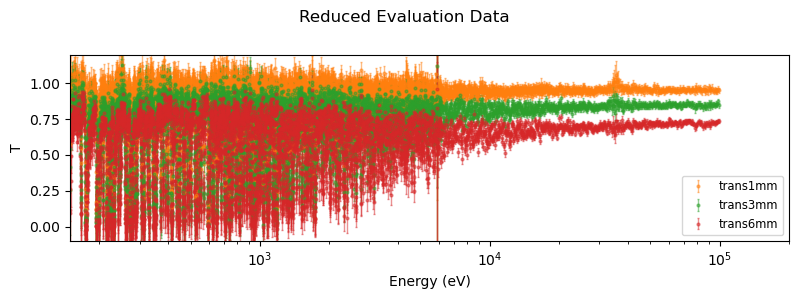

In [15]:
importlib.reload(myplot)
### setup in zipped lists 
datasets = [transdat1, transdat3, transdat6]
experiments= [exptrans1, exptrans3, exptrans6]

covariance_data = [{}, {}, transdat1_covfile, transdat3_covfile, transdat6_covfile]
templates = []


fig = myplot.plot_reduced_data_T(datasets, experiments,
                                 xlim=energy_range_T, #(.15e3, 2.5e3),
                               fig_size=(8,3))
fig.suptitle("Reduced Evaluation Data")
fig.tight_layout()


## Unknown measurement model
<!-- ![EvalT_RawData.png](attachment:EvalT_RawData.png) -->
The most challenging aspect of building a measurement model without full access to raw data is approximating the neutron and background spectra.
In this case, a spectrum and fitted background function are published in the journal article.
Here we will 'guess-and-check' parameters that create a similar picture.

<!-- <img src="./data/EvalT_RawData.png" alt="Alt text" width="500" height="300"> -->


#### Estimating the background

For the transmission methodology here, parameters b0o and b0s are independent measurements of a constant background for open and sample measurements respectively.
Parameters ko and ks are independent parameters estimated by the fixed notch resonance present during the open and sample measurements respectively.
Parameters a and b are used to represent the time-dependent background.
These parameters are correlated to one another and are estimated from a separate set of measurements.

Count rate for each of the notch points can be 'eye-balled'.
Additionaly, these notches correspond to strong (blackout) resonances in standard isotopes so the time-of-flight can be precisely deduced.

Uncertainties on k and b0 are independent and are given by counting statistics during the actual open and sample measurements.
Uncertainties on the a and b parameters are correlated and estimated by the goodness of fit to the notches in the background measurements.

Because we need to infer all of these parameters, and the published graph shows the object $bi*k*b0$, we can fit the entire model to our data.
Covariance estimates here given by goodness of fit will be much too large and include correlations on uncorrelated parameters.
To address this, we can take the estimates for the independent parameters as the independent, measured value and give some estimated uncertainty (5% here).
Then, taking those independent parameters as fixed, we can refit the a and b parameters to the object $bi$. 
This will fine-tune these parameters and give a more appropriate covariance based on goodness of fit.

#### Estimating the open spectrum
 
The open spectrum, for obvious reasons, will not be replicated near as well.
For the ideal synthetic data case you will have a measured open spectrum, however, that is not always possible.
Fortunately, the inherent 'cleanliness' of a transmission measurement makes this not such a big deal. 
Transmission is a ratio of sample-to-open spectra, and each spectrum is taken at the same facility under identical conditions (except for the presence of the target sample).
Because of this, experimentalists do not need to characterize the incident neutron flux under the assumptions that any features -- other than those induced by the target sample -- cancel one another out. 
In the same way, any improper approximation to the open spectra for synthetic data generation will cancel out.
So, reproducing just the general shape and magnitude should suffice.

Furthermore, this data is reported to be reliable between 0.15 keV and 100 keV, and the resolved resonance region ends around 3 keV.
Within the region 0.15-3 keV, the shape of the open spectrum is nearly identical to the background and does not include any extraneous features, such as the fixed notch of Co-59.



In [93]:
from ATARI.syndat import general_functions
from scipy.optimize import curve_fit

### Initial estimates of trig
trigo = 1e7
trigs = 2e7

t0=exptrans1.t0[0]
FP = exptrans1.FP[0]


In [94]:
# fit approximate notches to estimate parameters & covariance for background
def Bi_power(tof,a,b):
    return a*(tof**(-b))

def func(tof, a, b, ko, ks, b0o, b0s):
    bi = Bi_power(tof, a, b)
    k = np.array([ko] * int(len(tof)/2) + [ks] * int(len(tof)/2))
    b0 = np.array([b0o] * int(len(tof)/2) + [b0s] * int(len(tof)/2))
    return bi*k*b0

# estimated notches during background runs
bgp_s = np.array([2.1e3, 1.3e3,  6e2, 2.1e2])
bgp_o = np.array([2.8e3, 2.0e3, 8e2, 3e2])
bgE = np.array([84e3, 35e3, 2.8e3, 0.33e3])
bgtof = e_to_t(np.array(bgE), 100.14, True)*1e6

# eatimated cobalt fixed notch during production runs
Co_o = 1.9e2
Co_s = 1.3e2
CoE = 0.132e3
Cotof = e_to_t(np.array(CoE), 100.14, True)*1e6


### def get_initial_estimates():
initial = [1000, 1, 1,1, 10,10]
bounds = ([0,0, 0.2,0.2, 0,0],
        [np.inf, np.inf, 2,2, 100,100])

x = np.concatenate([bgtof, [Cotof], bgtof, [Cotof]])
y = np.concatenate([bgp_o, [Co_o], bgp_s, [Co_s]])

popt, _ = curve_fit(func, x, y, p0=initial)#, sigma=y*1e-5, absolute_sigma=True)
a,b, ko,ks, b0o, b0s = popt
# da,db, dko,dks, db0o, db0s = np.sqrt(np.diag(pcov))
# print(popt)
# print(np.sqrt(np.diag(pcov)))


### get better covariance estimate for a,b given other parameters
x2 = x
y2 = np.concatenate([bgp_o/ko-b0o, [Co_o/ko-b0o], bgp_s/ks-b0s, [Co_s/ks-b0s]])
popt2, abcov = curve_fit(Bi_power, x2, y2, p0=[a,b])
a,b = popt2
da,db = np.sqrt(np.diag(abcov))
# print("2")
# print(popt2)
# print(np.sqrt(np.diag(pcov2)))


### printout 
dko = ko*0.05
dks = ks*0.05
db0o = b0o*0.05
db0s = b0s*0.05

print("Estimated reduction parameters")

print()
print("Background function covariance is estimated based on the residual of the notch data to the fit")
print(f"a, da = {np.round(a, 3)}, {np.round(da, 3)}")
print(f"b, db = {np.round(b, 3)}, {np.round(db, 3)}")
print(f"%db   = {np.round(db/b, 3)} (reference reports 6%)")
print()
print(f"ab covariance = \n{abcov}")


print()
print("The following, independent parameters' uncertainty is estimated conservatively to be 4%")
print(f"ko, dko   = {np.round(ko, 3)},{np.round(dko, 3)}")
print(f"ks, dks   = {np.round(ks, 3)},{np.round(dks, 3)}")
print(f"b0o, db0o = {np.round(b0o, 3)},{np.round(db0o, 3)}")
print(f"b0s, db0s = {np.round(b0s, 3)},{np.round(db0s, 3)}")


Estimated reduction parameters

Background function covariance is estimated based on the residual of the notch data to the fit
a, da = 24265.832, 4002.64
b, db = 0.814, 0.047
%db   = 0.058 (reference reports 6%)

ab covariance = 
[[1.60211286e+07 1.87901859e+02]
 [1.87901859e+02 2.24240657e-03]]

The following, independent parameters' uncertainty is estimated conservatively to be 4%
ko, dko   = 1.528,0.076
ks, dks   = 1.179,0.059
b0o, db0o = 15.392,0.77
b0s, db0s = 14.311,0.716


In [95]:
### fit open spectrum from approximate points, same functional form as background 
co =    np.array([3e3,  2e3,      1.5e3,   9e2,    6e2,   3e2, 3e2])
tof_o = np.array([9e1,  1.6e2,    2e2,     3e2,    5e2,   8e2, 9e2])

def open_exp(tof, a, b):#, b0):
    return a*(tof**(-b)) #(a * np.exp(-b * tof) )#+ b0) 

popt, _ = curve_fit(open_exp, tof_o, co)
ao, bo = popt
print("open")
print(popt)

# tof = e_to_t(exptrans1.tof_grid, FP, True)*1e9 + t0 
tof = exptrans1.tof_grid*1e-3
cps_open_smooth = open_exp(tof, *popt)

bin_width = abs(np.append(np.diff(tof), np.diff(tof)[-1])*1e-6)
cts_open_approx = cps_open_smooth * bin_width * trigo
cts_open_measured = general_functions.pois_noise(cts_open_approx)

open_dataframe = pd.DataFrame({'tof'    :   tof,
                                'bw'    :   bin_width,
                                'ct'     :   cts_open_measured,
                                'dct'    :   np.sqrt(cts_open_measured)})

open_dataframe['E'] = exptrans1.energy_grid#t_to_e((open_dataframe.tof-t0)*1e-9, FP, True) 
open_dataframe['c'], open_dataframe['dc'] = general_functions.cts_to_ctr(open_dataframe.ct, open_dataframe.dct, open_dataframe.bw, trigo)

open
[2.11544534e+05 9.39522842e-01]


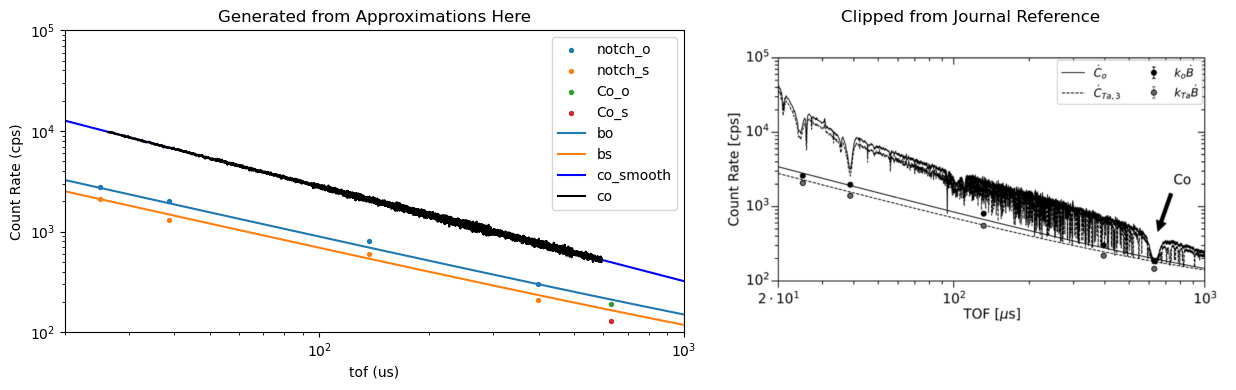

In [96]:
from PIL import Image
# journal_image = np.asarray(Image.open('./data/EvalT_RawData.png'))
journal_image = Image.open('./data/EvalT_RawData.png')



fake_tof = np.linspace(2e1,1e3, 1000)
Bi = Bi_power(fake_tof, a,b)

fig, axes = subplots(1,2, figsize=(13,4))

axes[0].scatter(bgtof, bgp_o, label='notch_o', s=8)
axes[0].scatter(bgtof, bgp_s, label='notch_s', s=8)
axes[0].scatter(Cotof, Co_o, label='Co_o', s=8)
axes[0].scatter(Cotof, Co_s, label='Co_s', s=8)

axes[0].plot(fake_tof, Bi*ko+b0o, label='bo')
axes[0].plot(fake_tof, Bi*ks+b0s, label='bs')

axes[0].plot(fake_tof, open_exp(fake_tof, *popt), 'b', label='co_smooth')
axes[0].plot(open_dataframe.tof, open_dataframe.c, color='k', label='co')
# plot(fake_tof, open_exp(fake_tof, *popt), 'b', label='co_smooth')

axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_ylim(1e2, 1e5)
axes[0].set_xlim(2e1, 1e3)
axes[0].set_ylabel('Count Rate (cps)')
axes[0].set_xlabel('tof (us)')
axes[0].legend()
axes[0].set_title("Generated from Approximations Here")

imgplot = axes[1].imshow(journal_image)
axes[1].axis('off')
axes[1].set_title("Clipped from Journal Reference")

fig.tight_layout()

In [86]:
def plot_behind():
        # from PIL import Image

    # im = imread('./data/EvalT_RawData.png')

    # fake_tof = np.linspace(2e1,1e3, 1000)
    # Bi = Bi_power(fake_tof, a,b)

    # figure(figsize=(10,5))

    # # rcParams["figure.figsize"] = [7.00, 3.50]
    # # rcParams["figure.autolayout"] = True
    # ax = gca()
    # im = ax.imshow(im)#, extent=[0, 300, 0, 300])


    # scatter(bgtof, bgp_o, label='notch_o', s=5)
    # scatter(bgtof, bgp_s, label='notch_s', s=5)
    # scatter(Cotof, Co_o, label='Co_o', s=5)
    # scatter(Cotof, Co_s, label='Co_s', s=5)

    # plot(fake_tof, Bi*ko+b0o, label='bo')
    # plot(fake_tof, Bi*ks+b0s, label='bs')

    # plot(fake_tof, open_exp(fake_tof, *popt), 'b', label='co_smooth')
    # plot(open_dataframe.tof, open_dataframe.c, color='k', label='co')
    # # plot(fake_tof, open_exp(fake_tof, *popt), 'b', label='co_smooth')

    # # imgplot = imshow(img)

    # yscale('log')
    # xscale('log')
    # ylim(1e2, 1e5)
    # xlim(2e1, 1e3)
    # ylabel('Count Rate (cps)')
    # xlabel('tof (us)')
    # legend()
    # tight_layout
    return

### Building Syndat measurement models with non-defaults

The monitor parameters can take defaults.
For the reduction methodology in both measurements, these values are assumed to be one with some uncertainty.
The rest of the parameters can be passed as kwargs to the Transmission_RPI class.
**Make sure to change the flag for functional form of the background function and pass in the approximated open spectrum**

In [97]:
par = {
'trigo' :   (trigo,  0),
'trigs' :   (trigs,  0),
'ks'    :   (ks, dks),
'ko'    :   (ko, dko),
'b0s'   :   (b0s,db0s),
'b0o'   :   (b0o,db0o),
'a_b'   :  ([a, b], abcov)
}

trans1mm_gen_meas = Transmission_RPI(**par, 
                                    open_neutron_spectrum = open_dataframe,
                                    bkg_func = 'power')
trans1mm_red_meas = Transmission_RPI(**par, 
                                    open_neutron_spectrum = open_dataframe,
                                    bkg_func = 'power')

trans3mm_gen_meas = Transmission_RPI(**par, 
                                    open_neutron_spectrum = open_dataframe,
                                    bkg_func = 'power')
trans3mm_red_meas = Transmission_RPI(**par, 
                                    open_neutron_spectrum = open_dataframe,
                                    bkg_func = 'power')

trans6mm_gen_meas = Transmission_RPI(**par, 
                                    open_neutron_spectrum = open_dataframe,
                                    bkg_func = 'power')
trans6mm_red_meas = Transmission_RPI(**par, 
                                    open_neutron_spectrum = open_dataframe,
                                    bkg_func = 'power')

# 1, 3 mm Capture Yield Data

Similar to the 1, 3, and 6 mm transmission data, we do not have access to any of the raw data used for capture measurements. 
Cannot just take rough approximate of open neutron spectrum because we actually need the shape for normalization -> use Li6 spectrum from 12mm transmission and normalize to Li6 yield rather than B4C yield.

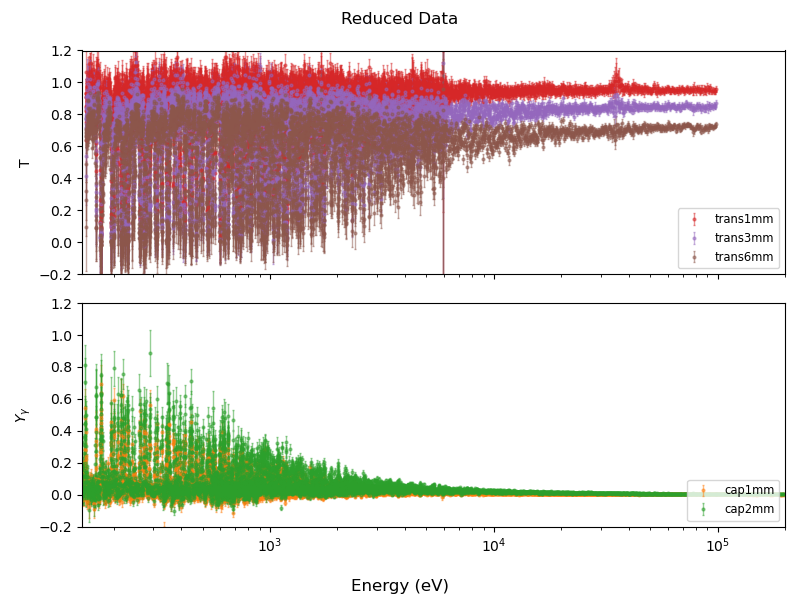

In [ ]:

### 1mm capture data
capdat1 = sammy_functions.readlst(os.path.realpath("./data/yield_ta1b_unsmooth.dat"))
expcap1 = Experimental_Model(title = "cap1mm",
                                reaction ="capture", 
                                energy_range = None,
                                energy_grid = capdat1.E.values, #np.sort(capdat1.E.values),
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )

capdat1 = capdat1.loc[(capdat1.E<max(expcap1.energy_range)) & (capdat1.E>min(expcap1.energy_range)), :]

### 2mm capture data
capdat2 = sammy_functions.readlst(os.path.realpath("./data/yield_ta2_unsmooth.dat"))
expcap2 = Experimental_Model(   title = "cap2mm",
                                reaction = "capture", 
                                energy_range = None,
                                energy_grid = np.sort(capdat2.E.values),
                                n = (0.011179, 0.0),
                                FP = (45.27, 0.05),
                                burst = (8.0,1.0),
                                temp = (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat2 = capdat2.loc[(capdat2.E<max(expcap2.energy_range)) & (capdat2.E>min(expcap2.energy_range)), :]


importlib.reload(myplot)

### setup in zipped lists 
datasets = [capdat1, capdat2, transdat1, transdat3, transdat6]
experiments= [expcap1, expcap2, exptrans1, exptrans3, exptrans6]

covariance_data = [{}, {}, transdat1_covfile, transdat3_covfile, transdat6_covfile]
templates = []


fig = myplot.plot_reduced_data(datasets, experiments,
                               xlim=(145, 200e3),
                               fig_size=(8,6))
fig.suptitle("Reduced Evaluation Data")
fig.tight_layout()

Text(0.5, 1.0, 'Reduced Validation Data')

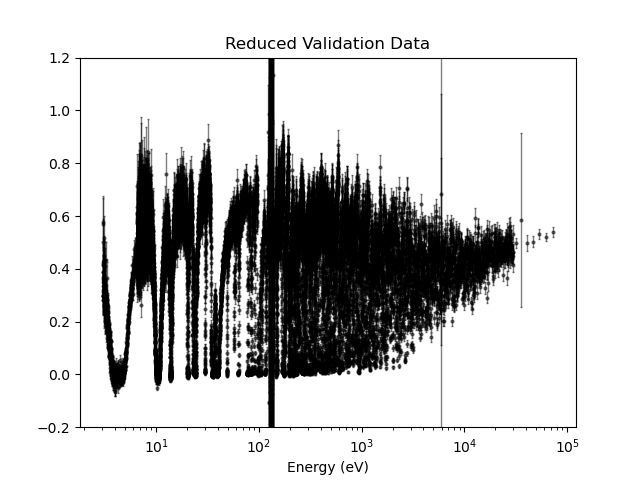

In [ ]:
importlib.reload(myplot)

# plot transmission
figure()

errorbar(transdat12.E, transdat12.exp, yerr= transdat12.exp_unc,
         fmt='.', alpha=0.5, color='k', linewidth=1.0, markersize=4, capsize=1, label=exptrans12.title)
xscale('log')
# yscale('log')
ylim([-0.2, 1.2])
xlabel("Energy (eV)")
title("Reduced Validation Data")

## Analysis

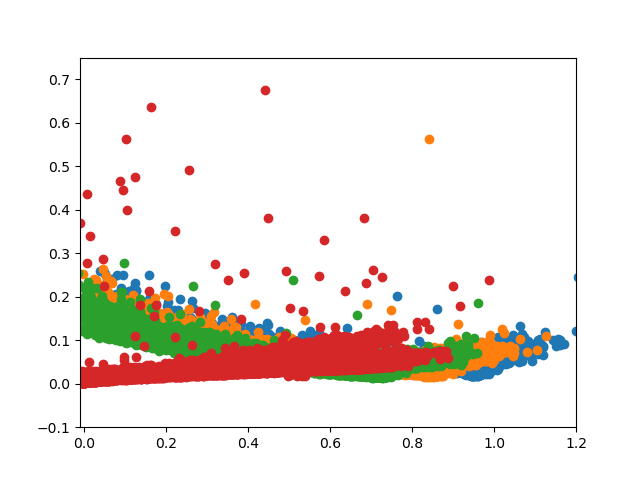

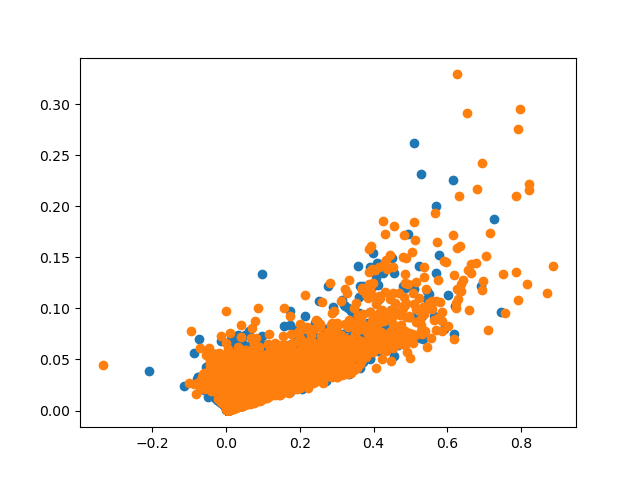

In [ ]:
figure()
scatter(transdat1.exp, transdat1.exp_unc)
scatter(transdat3.exp, transdat3.exp_unc)
scatter(transdat6.exp, transdat6.exp_unc)
scatter(transdat12.exp, transdat12.exp_unc)#/transdat12.exp 
xlim([-0.01,1.2])
ylim([-0.1, 0.75])

figure()
scatter(capdat1.exp, capdat1.exp_unc )
scatter(capdat2.exp, capdat2.exp_unc )

## 

In [ ]:


### add sammy templates to each experimental object
for exp in experiments:
    filepath = os.path.realpath(f'./data/template_{exp.title}_edited')
    exp.template = os.path.realpath(filepath)


matnum = 7328

jeff_file = os.path.realpath("./data/73-Ta-181g.jeff33")
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, sammyRTO)

energy_range_all = (150, 2500)
jeff_parameters = jeff_parameters[(jeff_parameters.E<max(energy_range_all)+5) & (jeff_parameters.E>min(energy_range_all)-5)]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*1
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))

jeff_parameters


Ta_pair = Particle_Pair(isotope="Ta181",
                        formalism="XCT",
                        ac=0.881271,     # scattering radius
                        M=180.948030,  # amu of target nucleus
                        m=1,           # amu of incident neutron
                        I=3.5,         # intrinsic spin, positive parity
                        i=0.5,         # intrinsic spin, positive parity
                        l_max=1,
                        energy_range = (3,2500))       # highest order l-wave to consider

# add spin group information for both s-wave resonances
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615, #46.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D=8.3031,
                       gn2_avg=332.24347, #35.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)


rto = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   False
                              })


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = jeff_parameters,  

    datasets= datasets,
    experiments = experiments,
    experimental_covariance=covariance_data,  #[{}, {}, {}, {}, {}], # 
    
    max_steps = 20,
    iterations = 2,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    LevMarVd= 5,
    initial_parameter_uncertainty = 0.05
    )

sammyOUT_JEFF = sammy_functions.run_sammy_YW(sammyINPyw, rto)

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
35,148.35,55.0,4.08900,1.0,1.0,1.0,2.0
36,149.80,55.0,6.62900,1.0,1.0,1.0,1.0
37,157.20,55.0,0.06857,1.0,1.0,1.0,1.0
38,159.80,55.0,0.26670,1.0,1.0,1.0,2.0
39,166.40,55.0,7.55555,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...
490,2477.70,75.0,58.67000,1.0,1.0,1.0,2.0
491,2479.70,75.0,51.56000,1.0,1.0,1.0,2.0
492,2486.50,75.0,75.11000,1.0,1.0,1.0,2.0
493,2495.80,75.0,135.10000,1.0,1.0,1.0,2.0


## Now Generate Syndat

In [ ]:
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.ModelData.measurement_models.capture_yield_rpi import Capture_Yield_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT

jb_reduction = pd.read_csv("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_reduction_data.csv")

open_df = copy(jb_reduction[["e", "tof", "cto", "dcto"]])
open_df.rename(columns={"e":"E", "cto":"c", "dcto":"dc"}, inplace=True)
open_df = open_df[ (open_df.E>min(energy_range_all)) & (open_df.E<max(energy_range_all)) ]
open_df['tof'] = open_df['tof']*1e3
open_df['bw'] = abs(np.append(np.diff(open_df['tof']), np.diff(open_df['tof'])[-1])*1e-9)


trans1mm_gen_meas = Transmission_RPI()
trans1mm_red_meas = Transmission_RPI()

trans3mm_gen_meas = Transmission_RPI()
trans3mm_red_meas = Transmission_RPI()


par = {
# 'trigs' :   (1.8e6,  0),
# 'trigo' :   (1e6,  0),
# 'm1'    :   (1,     0.016) ,#0.016
# 'm2'    :   (1,     0.008) ,#0.008
# 'm3'    :   (1,     0.018) ,#0.018
# 'm4'    :   (1,     0.005) ,#0.005
# 'ks'    :   (0.563, 10.240), #0.02402339737495515
# 'ko'    :   (1.471, 10.557), #0.05576763648617445
# 'b0s'   :   (9.9,   10.1) ,#0.1
# 'b0o'   :   (13.4,  10.7) ,#0.7
# 'a_b'   :  ([582.7768594580712, 0.05149689096209191],
#                         [[5.14395753e+03,  1.42659922e-1],
#                          [1.42659922e-1,   5.19135003e-05]])
}

trans6mm_gen_meas = Transmission_RPI(**par)
trans6mm_red_meas = Transmission_RPI(**par)

trans12mm_gen_meas = Transmission_RPI(open_neutron_spectrum = open_df)
trans12mm_red_meas = Transmission_RPI(open_neutron_spectrum = open_df)


cap1mm_gen_meas = Capture_Yield_RPI()
cap1mm_red_meas = Capture_Yield_RPI()

cap2mm_gen_meas = Capture_Yield_RPI()
cap2mm_red_meas = Capture_Yield_RPI()


In [ ]:
trans6mm_gen_meas.model_parameters.open_neutron_spectrum

In [ ]:
trans12mm_gen_meas.model_parameters.open_neutron_spectrum

,E,tof,c,dc,bw
0,202.045518,182288.0,322.80305,17.966721,2.560000e-08
1,202.103335,182262.4,319.26661,17.868033,2.560000e-08
2,202.161176,182236.8,314.01987,17.720606,2.560000e-08
3,202.219042,182211.2,290.76989,17.051976,2.560000e-08
4,202.276933,182185.6,314.19227,17.725470,2.560000e-08
...,...,...,...,...,...
391,226.695113,172278.4,368.07278,19.185223,2.560000e-08
392,226.763827,172252.8,345.54112,18.588736,2.560000e-08
393,226.832572,172227.2,363.83753,19.074526,2.560000e-08
394,226.901349,172201.6,360.45046,18.985533,2.560000e-08


AttributeError: 'NoneType' object has no attribute 'E'

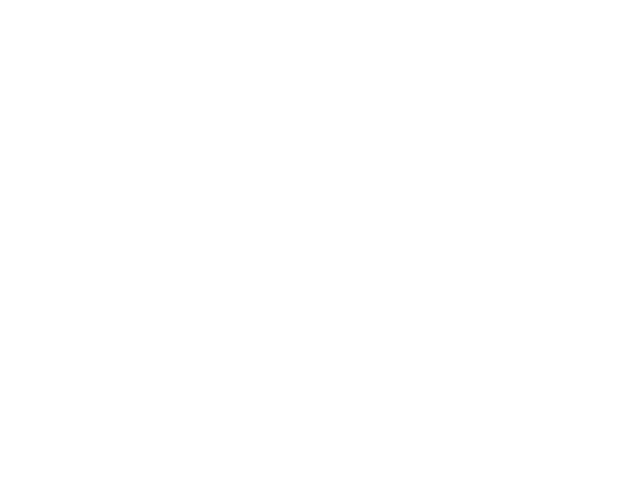

In [ ]:
# figure()
# scatter(trans6mm_gen_meas.model_parameters.open_neutron_spectrum.E, trans6mm_gen_meas.model_parameters.open_neutron_spectrum.c)
# scatter(trans12mm_gen_meas.model_parameters.open_neutron_spectrum.E,trans12mm_gen_meas.model_parameters.open_neutron_spectrum.c)

In [ ]:
synOPT = syndatOPT(calculate_covariance=True)
synOPT 

calculate_covariance: True
explicit_covariance: False
sampleRES: True
sampleTMP: True
sampleTNCS: True
sampleTURP: True
sample_counting_noise: True
save_raw_data: False
smoothTNCS: False

In [ ]:
synOPT.calculate_covariance = True
syndat_trans1mm = Syndat_Model(exptrans1,
                            trans1mm_gen_meas,
                            trans1mm_red_meas,
                            options = synOPT,
                            title='trans1mm')
syndat_trans3mm = Syndat_Model(exptrans3,
                            trans3mm_gen_meas,
                            trans3mm_red_meas,
                            options = synOPT,
                            title='trans3mm')
syndat_trans6mm = Syndat_Model(exptrans6,
                            trans6mm_gen_meas,
                            trans6mm_red_meas,
                            options = synOPT,
                            title='trans6mm')
syndat_trans12mm = Syndat_Model(exptrans12,
                            trans12mm_gen_meas,
                            trans12mm_red_meas,
                            options = synOPT,
                            title='trans12mm')


synOPT.calculate_covariance = False
syndat_cap1mm = Syndat_Model(expcap1,
                            cap1mm_gen_meas,
                            cap1mm_red_meas,
                            options = synOPT,
                            title='cap1mm')

syndat_cap2mm = Syndat_Model(expcap2,
                            cap2mm_gen_meas,
                            cap2mm_red_meas,
                            options = synOPT,
                            title='cap2mm')

In [ ]:
len(syndat_trans1mm.reductive_measurement_model.model_parameters.open_neutron_spectrum.E)
len(exptrans1.energy_grid)

199

In [ ]:
from ATARI.syndat.control import Syndat_Control


# TODO: where we should create & assign  template for each exp. model??


syndat_models= [syndat_trans1mm, syndat_trans3mm, syndat_trans6mm, syndat_trans12mm, syndat_cap1mm, syndat_cap2mm]

templates = []

for exp in experiments:
    filepath = os.path.realpath(f'./data/template_{exp.title}_edited')
    exp.template = os.path.realpath(filepath)

Ta_pair.resonance_ladder= sammyOUT_JEFF.par_post
synOPT.sampleRES = False
syndat = Syndat_Control(particle_pair= Ta_pair,
                        syndat_models = syndat_models,
                        model_correlations = None,
                        options=synOPT
                        )

rto = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True,
                              # "sammy_runDIR": os.path.realpath("/Users/noahwalton/Library/Mobile Documents/com~apple~CloudDocs/Research Projects/Resonance Fitting/ATARI_workspace/sammyrunDIR")
                              "sammy_runDIR": os.path.realpath("./sammy_rundir_py_gen")
                              })

syndat.sample(rto, num_samples=1)

In [ ]:
sample1 = syndat.get_sample(0)

In [ ]:
lengths = []
for key, val in sample1.items():
    print(key)
    print(len(val.pw_reduced))

trans1mm
199
trans3mm
199
trans6mm
199
trans12mm
396
cap1mm
127
cap2mm
127


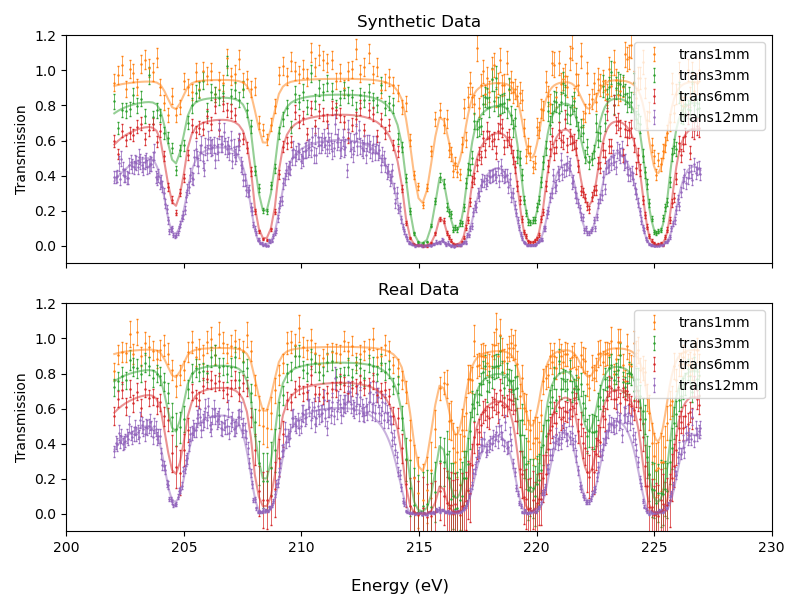

In [ ]:
### Plot 
fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

colors = ["C1", "C2", "C3", "C4"]
### Trans
for it, key in enumerate(['trans1mm', 'trans3mm','trans6mm', 'trans12mm']):
    axes[0].errorbar(sample1[key].pw_reduced.E, sample1[key].pw_reduced.exp, yerr=sample1[key].pw_reduced.exp_unc, zorder=0,
                                            fmt='.',  color=colors[it], linewidth=0.5, markersize=1.5, capsize=1, label=key)

    axes[0].plot(sample1[key].pw_reduced.E, sample1[key].pw_reduced.true, color=colors[it], alpha=0.5)

axes[0].set_ylabel("Transmission")
axes[0].set_title("Synthetic Data")

## real data 
for it, key in enumerate(['trans1mm', 'trans3mm','trans6mm', 'trans12mm']):
    axes[1].errorbar(datasets[it+2].E, datasets[it+2].exp, yerr=datasets[it+2].exp_unc, zorder=0,
                                            fmt='.',  color=colors[it], linewidth=0.5, markersize=1.5, capsize=1, label=key)

    axes[1].plot(sammyOUT_JEFF.pw_post[it+2].E, sammyOUT_JEFF.pw_post[it+2].theo_trans, color=colors[it], alpha=0.5)

axes[1].set_ylabel("Transmission")
axes[1].set_title("Real Data")

# ### Capture
# for ic, key in enumerate(['cap1mm', 'cap2mm']):
#     axes[1].errorbar(sample1[key].pw_reduced.E, sample1[key].pw_reduced.exp, yerr=sample1[key].pw_reduced.exp_unc, zorder=0, 
#                                             fmt='.', color=colors[ic], linewidth=0.5, markersize=1.5, capsize=1, label=key)
#     axes[1].plot(sample1[key].pw_reduced.E, sample1[key].pw_reduced.true, color=colors[ic], alpha=0.5)

# axes[1].set_ylabel(r"$Y_{\gamma}$")

### make it pretty
for ax in axes:
    ax.set_xlim([200,230])
    ax.set_ylim([-0.1,1.2])
    ax.legend()

fig.supxlabel('Energy (eV)')
fig.tight_layout()

In [ ]:
a_b, abcov = syndat_trans1mm.reductive_measurement_model.model_parameters.a_b
b0, _ = syndat_trans1mm.reductive_measurement_model.model_parameters.b0s
ks, _ = syndat_trans1mm.reductive_measurement_model.model_parameters.ks
# sample1['trans1mm'].pw_reduced.tof.values*1e-3

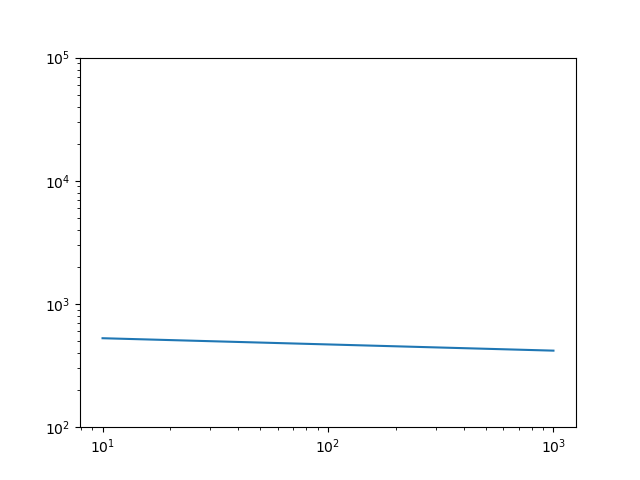

In [ ]:
from ATARI.syndat.general_functions import neutron_background_function

def neutron_background_function2(tof, a, b, c):
    return a*tof**(-b) + c

# tof = sample1['trans1mm'].pw_reduced.tof.values * 1e-3
tof = np.linspace(10,1000,1000)
figure()

# plot(tof, neutron_background_function(tof, a_b[0], a_b[1])*ks + b0)

plot(tof, neutron_background_function2(tof, a_b[0], a_b[1], b0) )

# ylim([1,1e5])
ylim([1e2,1e5])
yscale('log')
xscale('log')

Text(0.5, 0.01, 'Transmission Value')

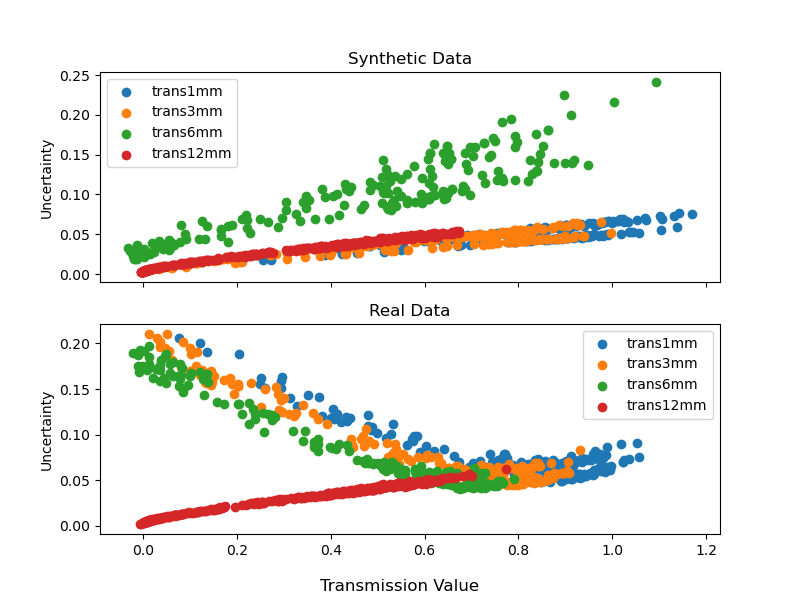

In [ ]:
fig, axes = subplots(2,1, figsize=(8,6), sharex=True)
axes[0].scatter(sample1['trans1mm'].pw_reduced.exp.values, sample1['trans1mm'].pw_reduced.exp_unc.values, label='trans1mm')#*transdat1.exp )
axes[0].scatter(sample1['trans3mm'].pw_reduced.exp.values, sample1['trans3mm'].pw_reduced.exp_unc.values, label='trans3mm')#*transdat3.exp )
axes[0].scatter(sample1['trans6mm'].pw_reduced.exp.values, sample1['trans6mm'].pw_reduced.exp_unc.values, label='trans6mm')#*transdat6.exp )
axes[0].scatter(sample1['trans12mm'].pw_reduced.exp.values, sample1['trans12mm'].pw_reduced.exp_unc.values, label='trans12mm')#/transdat12.exp 
axes[0].set_ylabel("Uncertainty")
axes[0].set_title("Synthetic Data")

axes[1].scatter(datasets[2].exp.values, datasets[2].exp_unc.values, label='trans1mm')#*transdat1.exp )
axes[1].scatter(datasets[3].exp.values, datasets[3].exp_unc.values, label='trans3mm')#*transdat3.exp )
axes[1].scatter(datasets[4].exp.values, datasets[4].exp_unc.values, label='trans6mm')#*transdat6.exp )
axes[1].scatter(datasets[5].exp.values, datasets[5].exp_unc.values, label='trans12mm')#/transdat12.exp 
axes[1].set_ylabel("Uncertainty")
axes[1].set_title("Real Data")

for ax in axes:
    # ax.set_xlim([200,230])
    # ax.set_ylim([-0.1,1.2])
    ax.legend()

fig.supxlabel("Transmission Value")
# figure()
# scatter(capdat1.exp, capdat1.exp_unc )
# scatter(capdat2.exp, capdat2.exp_unc )


In [ ]:
len(datasets[2].exp-sammyOUT_JEFF.pw_post[2].theo_trans)
# len( datasets[2].exp_unc)
sammyOUT_JEFF.pw_post[2]

,E,exp_xs,exp_xs_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,202.036981,36.815483,11.071372,16.404141,0.0,0.811902,0.050877,0.911333,NaN
1,202.199565,17.029604,10.806407,15.306685,0.0,0.908112,0.055544,0.917011,NaN
2,202.362345,13.978043,10.976658,14.422769,0.0,0.923933,0.057402,0.921610,NaN
3,202.525321,14.816059,10.588283,13.706059,0.0,0.919561,0.055109,0.925356,NaN
4,202.688494,-4.499633,12.535137,13.119242,0.0,1.025795,0.072779,0.928435,NaN
...,...,...,...,...,...,...,...,...,...
194,226.522995,27.562290,13.554495,12.350512,0.0,0.855557,0.065637,0.932483,NaN
195,226.619477,33.648001,12.988582,12.102956,0.0,0.826589,0.060767,0.933791,NaN
196,226.716020,16.803092,13.516738,12.040326,0.0,0.909277,0.069564,0.934122,NaN
197,226.812625,11.801036,13.134513,12.140382,0.0,0.935388,0.069538,0.933593,NaN


Text(0.5, 0.01, 'Residual to Fit')

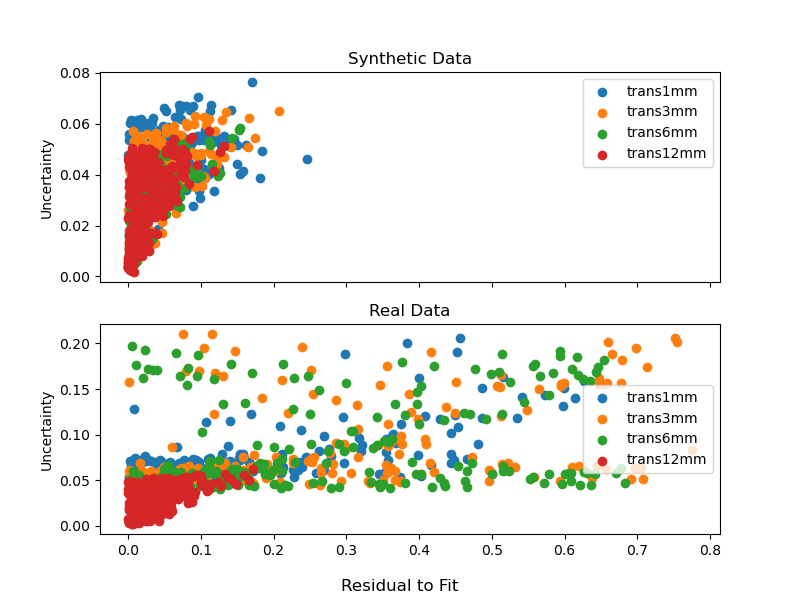

In [ ]:
fig, axes = subplots(2,1, figsize=(8,6), sharex=True)
axes[0].scatter(abs(sample1['trans1mm'].pw_reduced.exp-sammyOUT_JEFF.pw_post[2].theo_trans), sample1['trans1mm'].pw_reduced.exp_unc, label='trans1mm')#*transdat1.exp )
axes[0].scatter(abs(sample1['trans3mm'].pw_reduced.exp-sammyOUT_JEFF.pw_post[3].theo_trans), sample1['trans3mm'].pw_reduced.exp_unc, label='trans3mm')#*transdat3.exp )
axes[0].scatter(abs(sample1['trans6mm'].pw_reduced.exp-sammyOUT_JEFF.pw_post[4].theo_trans), sample1['trans6mm'].pw_reduced.exp_unc, label='trans6mm')#*transdat6.exp )
axes[0].scatter(abs(sample1['trans12mm'].pw_reduced.exp-sammyOUT_JEFF.pw_post[5].theo_trans), sample1['trans12mm'].pw_reduced.exp_unc, label='trans12mm')#/transdat12.exp 
axes[0].set_ylabel("Uncertainty")
axes[0].set_title("Synthetic Data")

axes[1].scatter(abs(datasets[2].exp.values-sammyOUT_JEFF.pw_post[2].theo_trans.values), datasets[2].exp_unc.values, label='trans1mm')#*transdat1.exp )
axes[1].scatter(abs(datasets[3].exp.values-sammyOUT_JEFF.pw_post[3].theo_trans.values), datasets[3].exp_unc.values, label='trans3mm')#*transdat3.exp )
axes[1].scatter(abs(datasets[4].exp.values-sammyOUT_JEFF.pw_post[4].theo_trans.values), datasets[4].exp_unc.values, label='trans6mm')#*transdat6.exp )
axes[1].scatter(abs(datasets[5].exp.values-sammyOUT_JEFF.pw_post[5].theo_trans.values), datasets[5].exp_unc.values, label='trans12mm')#/transdat12.exp 
axes[1].set_ylabel("Uncertainty")
axes[1].set_title("Real Data")

for ax in axes:
    # ax.set_xlim([200,230])
    # ax.set_ylim([-0.1,1.2])
    ax.legend()
fig.supxlabel("Residual to Fit")

In [ ]:
sample1.keys()

dict_keys(['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm'])

In [ ]:
#sample1[list(sample1.keys())[0]].par_true
#sample1['cap1mm'].par_true
sample1['trans1mm'].par_true

,E,Gg,Gn1,J_ID,gg2,gn2,Jpi,L
0,203.598407,67.860624,0.331773,1.0,33.930312,6.038316,3.0,0.0
1,214.594965,58.114658,104.721051,1.0,29.057329,1856.462625,3.0,0.0
2,225.965178,63.346282,39.278886,1.0,31.673141,678.578948,3.0,0.0
3,211.582549,65.438043,14.580964,2.0,32.719022,260.320463,4.0,0.0
4,220.808384,69.911565,7.951896,2.0,34.955782,138.971234,4.0,0.0


In [ ]:
start = copy(sample1['trans1mm'].par_true)
start["varyE"] = np.ones(len(start))
start["varyGg"] = np.ones(len(start))
start["varyGn1"] = np.ones(len(start))
start

,E,Gg,Gn1,J_ID,gg2,gn2,Jpi,L,varyE,varyGg,varyGn1
0,203.598407,67.860624,0.331773,1.0,33.930312,6.038316,3.0,0.0,1.0,1.0,1.0
1,214.594965,58.114658,104.721051,1.0,29.057329,1856.462625,3.0,0.0,1.0,1.0,1.0
2,225.965178,63.346282,39.278886,1.0,31.673141,678.578948,3.0,0.0,1.0,1.0,1.0
3,211.582549,65.438043,14.580964,2.0,32.719022,260.320463,4.0,0.0,1.0,1.0,1.0
4,220.808384,69.911565,7.951896,2.0,34.955782,138.971234,4.0,0.0,1.0,1.0,1.0


In [ ]:

datasets = [sample1['trans1mm'].pw_reduced, sample1['trans3mm'].pw_reduced, sample1['trans6mm'].pw_reduced, sample1['cap1mm'].pw_reduced, sample1['cap2mm'].pw_reduced]
experiments= [exptrans1, exptrans3, exptrans6, expcap1, expcap2]
covariance_data = [sample1['trans1mm'].covariance_data, sample1['trans3mm'].covariance_data, sample1['trans6mm'].covariance_data, {}, {}]


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = start,  

    datasets= datasets,
    experiments = experiments,
    experimental_covariance= covariance_data, 
    
    max_steps = 10,
    iterations = 3,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    LevMarVd= 5,
    initial_parameter_uncertainty = 0.01
    )



In [ ]:
sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']


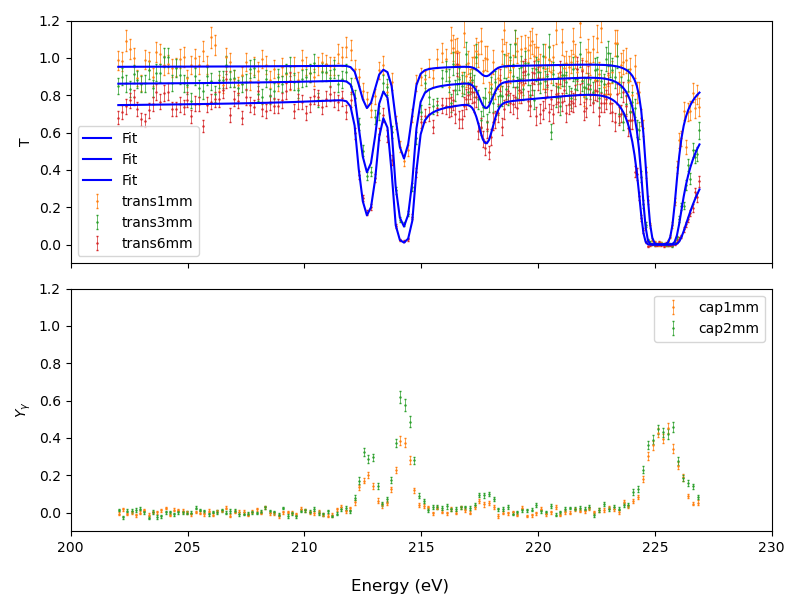

In [ ]:
### Plot 
fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

colors = ["C1", "C2", "C3", "C4"]
### Trans
for it, key in enumerate(['trans1mm', 'trans3mm','trans6mm']):
    axes[0].errorbar(sample1[key].pw_reduced.E, sample1[key].pw_reduced.exp, yerr=sample1[key].pw_reduced.exp_unc, zorder=0,
                                            fmt='.',  color=colors[it], linewidth=0.5, markersize=1.5, capsize=1, label=key)
    # axes[0].plot(sample1[key].pw_reduced.E, sample1[key].pw_reduced.true, color=colors[it], alpha=0.5)

axes[0].set_ylabel("T")

### Capture
for ic, key in enumerate(['cap1mm', 'cap2mm']):
    axes[1].errorbar(sample1[key].pw_reduced.E, sample1[key].pw_reduced.exp, yerr=sample1[key].pw_reduced.exp_unc, zorder=0, 
                                            fmt='.', color=colors[ic], linewidth=0.5, markersize=1.5, capsize=1, label=key)
    # axes[1].plot(sample1[key].pw_reduced.E, sample1[key].pw_reduced.true, color=colors[ic], alpha=0.5)

axes[1].set_ylabel(r"$Y_{\gamma}$")

axes[0].plot(sammyOUT.pw_post[0].E, sammyOUT.pw_post[0].theo_trans, color='b', label='Fit')
axes[0].plot(sammyOUT.pw_post[1].E, sammyOUT.pw_post[1].theo_trans, color='b', label='Fit')
axes[0].plot(sammyOUT.pw_post[2].E, sammyOUT.pw_post[2].theo_trans, color='b', label='Fit')

### make it pretty
for ax in axes:
    ax.set_xlim([200,230])
    ax.set_ylim([-0.1,1.2])
    ax.legend()

fig.supxlabel('Energy (eV)')
fig.tight_layout()



In [ ]:
sample1['trans1mm'].covariance_data['diag_stat']

,var_stat
E,
202.036981,0.001944
202.199565,0.001907
202.362345,0.002393
202.525321,0.002168
202.688494,0.001865
...,...
226.522995,0.002185
226.619477,0.002407
226.716020,0.002112


In [ ]:
D = copy(sample1['trans1mm'].pw_reduced.exp)
T = copy(sammyOUT.pw_post[0].theo_trans)
# T = copy(sample1['trans1mm'].pw_reduced.true)

Cs = sample1['trans1mm'].covariance_data['Cov_sys']
Js = sample1['trans1mm'].covariance_data['Jac_sys']
stat = sample1['trans1mm'].covariance_data['diag_stat']

Cov = Js.T @ Cs @ Js + np.diag(stat['var_stat'])

(D-T) @ np.linalg.inv(Cov.values) @ (D-T).T

414.6676491040258

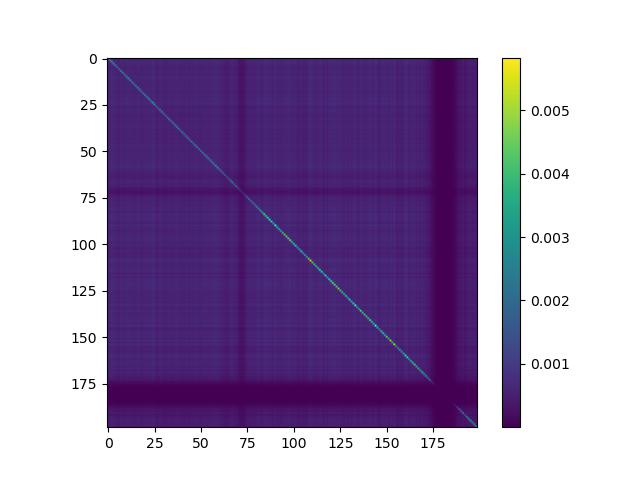

In [ ]:
figure()
imshow(Cov)
colorbar()

In [ ]:
sample1['trans1mm'].pw_reduced

,tof,E,true,exp,exp_unc
0,512680.366109,202.036981,0.951913,0.987931,0.050473
1,512475.545556,202.199565,0.951957,0.980429,0.050017
2,512270.725086,202.362345,0.952001,1.091773,0.055956
3,512065.904834,202.525321,0.952046,1.047001,0.053343
4,511861.084216,202.688494,0.952092,1.000743,0.049814
...,...,...,...,...,...
194,484363.938294,226.522995,0.750127,0.716923,0.050044
195,484261.528097,226.619477,0.771441,0.814181,0.053052
196,484159.117794,226.716020,0.788816,0.729560,0.049402
197,484056.707664,226.812625,0.803252,0.803451,0.052524


In [ ]:
sammyOUT.pw_post[0]

,E,exp_xs,exp_xs_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,202.036981,2.145304,9.026431,8.696556,0.0,0.987931,0.050473,0.951969,NaN
1,202.199565,3.492058,9.013326,8.688469,0.0,0.980429,0.050017,0.952013,NaN
2,202.362345,-15.512894,9.055197,8.680148,0.0,1.091773,0.055956,0.952058,NaN
3,202.525321,-8.114821,9.001480,8.671661,0.0,1.047001,0.053343,0.952103,NaN
4,202.688494,-0.131223,8.794526,8.663014,0.0,1.000743,0.049814,0.952150,NaN
...,...,...,...,...,...,...,...,...,...
194,226.522995,58.796261,12.332839,51.416140,0.0,0.716923,0.050044,0.747504,NaN
195,226.619477,36.320244,11.512360,46.364465,0.0,0.814181,0.053052,0.769186,NaN
196,226.716020,55.709128,11.963743,42.354157,0.0,0.729560,0.049402,0.786845,NaN
197,226.812625,38.664148,11.550000,39.092223,0.0,0.803451,0.052524,0.801507,NaN
